# makemore: bigram exercises
-----
 Exercises
----
1. Train a [**trigram**](#1) language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either [counting](#1a) or a [neural net](#1b). Evaluate the loss; Did it improve over a **bigram** model?
2. [Split up the dataset](#2) randomly into <u>80% train set, 10% dev set, 10% test set</u>. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
3. Use the <u>[dev set to tune the strength of smoothing (or regularization)](#3)</u> for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
4. We saw that our 1-hot vectors merely select a row of `W`, so producing these vectors explicitly feels wasteful. Can you delete our use of `F.one_hot` in favor of [simply indexing into rows of `W`](#4)?
5. [Look up and use `F.cross_entropy` instead](#5). You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead?
6. [Meta-exercise!](#6) Think of a fun/interesting exercise and complete it.

In [303]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Trigram Model

## 1.1. Counting approach

In [189]:
names = open('names.txt', 'r').read().splitlines()

In [190]:
letters = sorted(list(set(''.join(names))))
stoi = {letter:i+1 for i,letter in enumerate(letters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
N = torch.zeros((27, 27, 27), dtype=torch.int32)

In [191]:
for name in names:
    chs = ['.', '.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]        
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1       

In [193]:
P = (N+1).float()
P /= P.sum(dim=2, keepdim=True)

In [194]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    p_temp = P_first[0]
    out = []
    ix1 = 0
    ix2 = 0
    while True:
        ix3 = torch.multinomial(P[ix1, ix2], num_samples=1, replacement = True, generator = g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1 = ix2
        ix2 = ix3
    print(''.join(out))

junide.
jakasid.
prelay.
adin.
kairritoper.
sathen.
sameia.
yanileniassibduinrwin.
lessiyanayla.
te.


In [195]:
nll = 0
n = 0
for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]        
        ix3 = stoi[ch3]
        nll -= P[ix1, ix2, ix3].log()
        n += 1

print(f'Average negative log likelihood is {nll/n:.5f}')

Average negative log likelihood is 2.09275


## 1.2 Neural Network

In [325]:
xs = []
ys = []

for name in names:
    chs = ['.', '.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append((stoi[ch1], stoi[ch2]))
        ys.append(stoi[ch3])
xs = torch.tensor(xs) 
ys = torch.tensor(ys)
num = ys.nelement()

In [326]:
epochs = 250
lr = 50
alpha = 0
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)
xenc = F.one_hot(xs, num_classes=27).float()
xenc = torch.hstack((xenc[:,0,:], xenc[:,1,:]))
for i in range(epochs):
    logits = xenc @ W
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() + alpha*(W**2).mean()
    
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -lr * W.grad
    if i >= epochs-10:
        print(loss)

tensor(2.3682, grad_fn=<AddBackward0>)
tensor(2.3918, grad_fn=<AddBackward0>)
tensor(2.3779, grad_fn=<AddBackward0>)
tensor(2.4282, grad_fn=<AddBackward0>)
tensor(2.3680, grad_fn=<AddBackward0>)
tensor(2.3916, grad_fn=<AddBackward0>)
tensor(2.3777, grad_fn=<AddBackward0>)
tensor(2.4280, grad_fn=<AddBackward0>)
tensor(2.3678, grad_fn=<AddBackward0>)
tensor(2.3915, grad_fn=<AddBackward0>)


In [327]:
g = torch.Generator().manual_seed(2147483647)

for i in range(15):
    out = []
    ix1, ix2 = 0, 0
    while True:
        xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).reshape(1, -1).float()
        logits = xenc @ W
        count = logits.exp()
        probs = count / count.sum(dim=1, keepdim=True)
        
        ix3 = torch.multinomial(probs.flatten(), num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1 = ix2
        ix2 = ix3
    print(''.join(out))

juwide.
janasad.
alen.
amainn.
kai.
ritoleras.
tee.
adannaauranileniassibdainrwi.
ta.
saisiely.
arte.
farmurthafontumer.
fans.
jah.
jayl.


# 2. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits.

In [328]:
x_train, x_rest, y_train, y_rest = train_test_split(xs.numpy(), ys.numpy(), train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5)

x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
x_val, y_val = torch.tensor(x_val), torch.tensor(y_val)
x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

In [329]:
epochs = 250
lr = 40
alpha = 0
g = torch.Generator().manual_seed(2147483647)
num = y_train.numel()
W = torch.randn((54, 27), generator=g, requires_grad=True)
xenc = F.one_hot(x_train, num_classes=27).float()
xenc = torch.hstack((xenc[:,0,:], xenc[:,1,:]))
for i in range(epochs):
    logits = xenc @ W
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), y_train].log().mean() + alpha*(W**2).mean()
    
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -lr * W.grad
    if i >= epochs-10:
        print(loss)

tensor(2.3637, grad_fn=<AddBackward0>)
tensor(2.3569, grad_fn=<AddBackward0>)
tensor(2.3635, grad_fn=<AddBackward0>)
tensor(2.3568, grad_fn=<AddBackward0>)
tensor(2.3634, grad_fn=<AddBackward0>)
tensor(2.3567, grad_fn=<AddBackward0>)
tensor(2.3633, grad_fn=<AddBackward0>)
tensor(2.3566, grad_fn=<AddBackward0>)
tensor(2.3632, grad_fn=<AddBackward0>)
tensor(2.3564, grad_fn=<AddBackward0>)


In [330]:
xenc_val = F.one_hot(x_val, num_classes=27).float()
xenc_val = torch.hstack((xenc_val[:,0,:], xenc_val[:,1,:]))
num_val = y_val.numel()

xenc_test = F.one_hot(x_test, num_classes=27).float()
xenc_test = torch.hstack((xenc_test[:,0,:], xenc_test[:,1,:]))
num_test = y_test.numel()

In [331]:
logits = xenc_val @ W
count = logits.exp()
probs = count / count.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(num_val), y_val].log().mean() + alpha*(W**2).mean()
print(f'Loss on validation (dev) set is {loss:.5f}')

Loss on validation (dev) set is 2.37060


In [332]:
logits = xenc_test @ W
count = logits.exp()
probs = count / count.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(num_test), y_test].log().mean() + alpha*(W**2).mean()
print(f'Loss on test set is {loss:.5f}')

Loss on test set is 2.37644


Loss is larger on Test and dev sets.

### Regularization

In [333]:
loss_train = []
loss_val = []
alphas = torch.linspace(0, 0.1, 11)
alphas

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000])

In [334]:
W = torch.randn((54, 27), generator=g, requires_grad=True)
for alpha in alphas:
    alpha = alpha.item()
    epochs = 250
    lr = 50
    g = torch.Generator().manual_seed(2147483647)
    num = y_train.numel()
    xenc = F.one_hot(x_train, num_classes=27).float()
    xenc = torch.hstack((xenc[:,0,:], xenc[:,1,:]))
    for i in range(epochs):
        logits = xenc @ W
        count = logits.exp()
        probs = count / count.sum(dim=1, keepdim=True)
        loss = -probs[torch.arange(num), y_train].log().mean() + alpha*(W**2).mean()
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad
        
    loss_train.append(loss.item())

    logits = xenc_val @ W
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num_val), y_val].log().mean() + alpha*(W**2).mean()
    loss_val.append(loss.item())

Text(0, 0.5, 'loss')

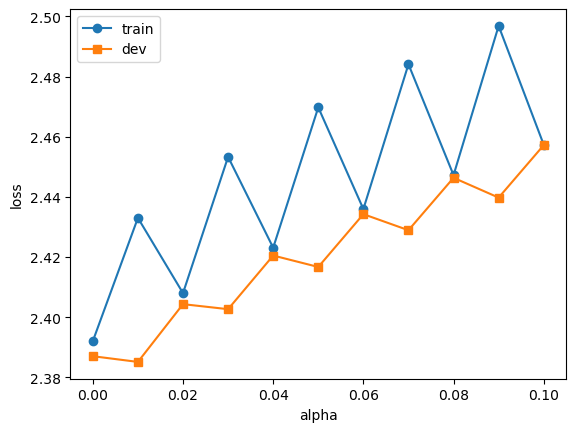

In [335]:
plt.figure()
plt.plot(alphas, loss_train, marker='o')
plt.plot(alphas, loss_val, marker='s')
plt.legend(['train', 'dev'])
plt.xlabel('alpha')
plt.ylabel('loss')

In [338]:
epochs = 250
lr = 40
alpha = 0.01
g = torch.Generator().manual_seed(2147483647)
num = y_train.numel()
W = torch.randn((54, 27), generator=g, requires_grad=True)
xenc = F.one_hot(x_train, num_classes=27).float()
xenc = torch.hstack((xenc[:,0,:], xenc[:,1,:]))
for i in range(epochs):
    logits = xenc @ W
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), y_train].log().mean() + alpha*(W**2).mean()
    
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -lr * W.grad
    if i >= epochs-10:
        print(loss)

tensor(2.3742, grad_fn=<AddBackward0>)
tensor(2.3674, grad_fn=<AddBackward0>)
tensor(2.3741, grad_fn=<AddBackward0>)
tensor(2.3673, grad_fn=<AddBackward0>)
tensor(2.3740, grad_fn=<AddBackward0>)
tensor(2.3672, grad_fn=<AddBackward0>)
tensor(2.3739, grad_fn=<AddBackward0>)
tensor(2.3671, grad_fn=<AddBackward0>)
tensor(2.3738, grad_fn=<AddBackward0>)
tensor(2.3670, grad_fn=<AddBackward0>)


In [339]:
logits = xenc_test @ W
count = logits.exp()
probs = count / count.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(num_test), y_test].log().mean() + alpha*(W**2).mean()
print(f'Loss on test set is {loss:.5f}')

Loss on test set is 2.38692


# 4. Getting rid of one hot encoding

In [355]:
epochs = 250
lr = 40
alpha = 0.01
g = torch.Generator().manual_seed(2147483647)
num = y_train.numel()
W = torch.randn((54, 27), generator=g, requires_grad=True)
xsp = x_train + torch.tensor([0, 27]).reshape((1,2))
for i in range(epochs):
    logits = W[xsp].sum(dim=1)
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), y_train].log().mean() + alpha*(W**2).mean()
    
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -lr * W.grad
    if i >= epochs-10:
        print(loss)

tensor(2.3742, grad_fn=<AddBackward0>)
tensor(2.3674, grad_fn=<AddBackward0>)
tensor(2.3741, grad_fn=<AddBackward0>)
tensor(2.3673, grad_fn=<AddBackward0>)
tensor(2.3740, grad_fn=<AddBackward0>)
tensor(2.3672, grad_fn=<AddBackward0>)
tensor(2.3739, grad_fn=<AddBackward0>)
tensor(2.3671, grad_fn=<AddBackward0>)
tensor(2.3738, grad_fn=<AddBackward0>)
tensor(2.3670, grad_fn=<AddBackward0>)


In [356]:
xsp_test = x_test + torch.tensor([0, 27]).reshape((1,2))
logits = W[xsp_test].sum(dim=1)
count = logits.exp()
probs = count / count.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(num_test), y_test].log().mean() + alpha*(W**2).mean()
print(f'Loss on test set is {loss:.5f}')

Loss on test set is 2.38694


# 5. F.cross_entropy()

In [359]:
epochs = 250
lr = 40
alpha = 0.01
g = torch.Generator().manual_seed(2147483647)
num = y_train.numel()
W = torch.randn((54, 27), generator=g, requires_grad=True)
xsp = x_train + torch.tensor([0, 27]).reshape((1,2))
for i in range(epochs):
    logits = W[xsp].sum(dim=1)
    loss = F.cross_entropy(logits, y_train) + alpha * (W**2).mean()
    
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -lr * W.grad
    if i >= epochs-10:
        print(loss)


tensor(2.3742, grad_fn=<AddBackward0>)
tensor(2.3674, grad_fn=<AddBackward0>)
tensor(2.3741, grad_fn=<AddBackward0>)
tensor(2.3673, grad_fn=<AddBackward0>)
tensor(2.3740, grad_fn=<AddBackward0>)
tensor(2.3672, grad_fn=<AddBackward0>)
tensor(2.3739, grad_fn=<AddBackward0>)
tensor(2.3671, grad_fn=<AddBackward0>)
tensor(2.3738, grad_fn=<AddBackward0>)
tensor(2.3670, grad_fn=<AddBackward0>)


In [360]:
logits = xenc_test @ W
loss = F.cross_entropy(logits, y_test) + alpha * (W**2).mean()
print(f'Loss on test set is {loss:.5f}')

Loss on test set is 2.38695
